### Importing 3rd party libraries

In [349]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
from shapely.geometry import Point
import shapely
import reverse_geocoder as rg
import sklearn as sk
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(rc={'figure.figsize':(13.7,10.27)})
sns.set_style("whitegrid")
sns.set_color_codes()

### Importing Dask related libraries

In [2]:
from dask.distributed import Client
import dask.bag as db
import dask.dataframe as dd
import dask.array as da
import dask
from ast import literal_eval
from collections.abc import MutableMapping
from collections import Counter
import io
import os

### Importing surprise related libraries

In [3]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection import cross_validate, GridSearchCV
import pandas as pd
import numpy as np
import os, io
from surprise import KNNBasic, KNNWithMeans
from surprise import SVDpp
from surprise import SVD
from surprise import accuracy

### Import Sklearn libraries

In [4]:
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
Client()

Client Scheduler: tcp://127.0.0.1:57385 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


### Loading and Exploring preprocessed dataframe

In [6]:
joined_df = dd.read_csv('data/joined_df.csv').compute()

In [7]:
joined_df.columns

Index(['Unnamed: 0', 'rating', 'reviewerName', 'categories', 'gPlusPlaceId',
       'gPlusUserId', 'user_lat', 'user_long', 'placeName', 'price', 'address',
       'place_lat', 'place_long'],
      dtype='object')

In [8]:
joined_df = joined_df.loc[:, ~joined_df.columns.str.match('Unnamed')]

In [9]:
joined_df.describe()

,rating,user_lat,user_long,place_lat,place_long
count,4.102647e+06,1.019908e+06,1.019908e+06,4.102647e+06,4.102647e+06
mean,3.963454e+00,3.543534e+01,-4.230559e+01,3.537519e+01,-3.944279e+01
std,1.130273e+00,1.846955e+01,7.340014e+01,1.788234e+01,7.371885e+01
min,0.000000e+00,-9.000000e+01,-1.764769e+02,-5.484173e+01,-1.800000e+02
25%,3.000000e+00,3.305811e+01,-9.571289e+01,3.271132e+01,-9.309486e+01
50%,4.000000e+00,3.975509e+01,-7.516379e+01,3.974303e+01,-7.401006e+01
75%,5.000000e+00,4.530182e+01,6.123373e+00,4.498173e+01,7.134800e+00
max,5.000000e+00,9.000000e+01,1.790000e+02,7.653802e+01,1.800000e+02


In [10]:
joined_df 

,rating,reviewerName,categories,gPlusPlaceId,gPlusUserId,user_lat,user_long,placeName,price,address,place_lat,place_long
0,4.0,william spindler,"['Asian Restaurant', 'Chinese Restaurant']",106591714648856494903,100000032416892623125,NaN,NaN,Peking Chinese Restaurant,$$$,"['860 Main St', 'Red Bluff, CA 96080']",40.179159,-122.236162
1,5.0,william spindler,"['European Restaurant', 'Italian Restaurant', ...",109420033090810328045,100000032416892623125,NaN,NaN,Firehouse Pizza,$$,"['734 Main St', 'Red Bluff, CA 96080']",40.178074,-122.235234
2,5.0,william spindler,['Barbecue Restaurant'],111623070919810985923,100000032416892623125,NaN,NaN,Two Buds Barbeque,NaN,"['22825 Antelope Blvd', 'Red Bluff, CA 96080']",40.184955,-122.186557
3,4.0,william spindler,['Restaurant'],113854191152597312098,100000032416892623125,NaN,NaN,Bud's Jolly Kone,NaN,"['455 Antelope Blvd', 'Red Bluff, CA 96080']",40.185961,-122.209742
4,5.0,william spindler,['Mexican Restaurant'],115827996910815192564,100000032416892623125,NaN,NaN,La Corona,$$,"['914 Walnut St', 'Red Bluff, CA 96080']",40.175064,-122.242574
...,...,...,...,...,...,...,...,...,...,...,...,...
196648,2.0,charles mckinney,"['Hamburger Restaurant', 'Fast Food Restaurant']",116458473784504954830,118446742455312620560,NaN,NaN,Fatburger,NaN,"['6780 Cherry Ave', 'Long Beach, CA 90805']",33.878048,-118.168365
196649,2.0,charles mckinney,"['Mexican Restaurant', 'Latin American Restaur...",117332598175065149705,118446742455312620560,NaN,NaN,Super Mex,NaN,"['5660 Atlantic Ave', 'Long Beach, CA 90805']",33.859250,-118.184753
196650,4.0,charles mckinney,"['Hot Dog Restaurant', 'Takeout Restaurant', '...",117868066122653879601,118446742455312620560,NaN,NaN,Wienerschnitzel,$$$,"['1300 E Rosecrans Ave', 'Compton, CA 90221']",33.903287,-118.209676
196651,1.0,charles mckinney,"['Buffet Restaurant', 'American Restaurant']",117952004983617019485,118446742455312620560,NaN,NaN,HomeTown Buffet,$$,"['3102 E Imperial Hwy', 'Lynwood, CA 90262']",33.930282,-118.216058


In [88]:
def places_filter(df, lat_l, lat_h, lon_l, lon_h):
    """Utility place filter function to filter us cities and states
       from rest of the world
       
       Input:
       df (Pandas DataFrame): input dataframe with location cordinates
       lat_l (Float): Source location latitude
       lat_h (Float): Destination location latitude
       lon_l (Float): Source location longitude
       lon_h (Float): Destination location longitude
       
       return (List): List of filtered placed as per the cordinates"""
    filtered_places = []
    for d in df.itertuples(index=False):
        if ((d.place_lat >= lat_l) \
            & (d.place_lat <= lat_h) \
            & (d.place_long >= lon_l) \
            & (d.place_long <= lon_h)):
            filtered_places.append(d)
    return filtered_places

5:36: E502 the backslash is redundant between brackets
6:38: E502 the backslash is redundant between brackets
7:39: E502 the backslash is redundant between brackets
8:5: E129 visually indented line with same indent as next logical line
11:1: W391 blank line at end of file


### Filtering orginal dataframe places to USA

In [12]:
%%time
usa_df = places_filter(joined_df, 19.50139, 64.85694, -161.75583, -68.01197)

CPU times: user 13.8 s, sys: 490 ms, total: 14.3 s
Wall time: 14.3 s


In [13]:
usa_df = pd.DataFrame(usa_df)

In [14]:
usa_df

,rating,reviewerName,categories,gPlusPlaceId,gPlusUserId,user_lat,user_long,placeName,price,address,place_lat,place_long
0,4.0,william spindler,"['Asian Restaurant', 'Chinese Restaurant']",106591714648856494903,100000032416892623125,NaN,NaN,Peking Chinese Restaurant,$$$,"['860 Main St', 'Red Bluff, CA 96080']",40.179159,-122.236162
1,5.0,william spindler,"['European Restaurant', 'Italian Restaurant', ...",109420033090810328045,100000032416892623125,NaN,NaN,Firehouse Pizza,$$,"['734 Main St', 'Red Bluff, CA 96080']",40.178074,-122.235234
2,5.0,william spindler,['Barbecue Restaurant'],111623070919810985923,100000032416892623125,NaN,NaN,Two Buds Barbeque,NaN,"['22825 Antelope Blvd', 'Red Bluff, CA 96080']",40.184955,-122.186557
3,4.0,william spindler,['Restaurant'],113854191152597312098,100000032416892623125,NaN,NaN,Bud's Jolly Kone,NaN,"['455 Antelope Blvd', 'Red Bluff, CA 96080']",40.185961,-122.209742
4,5.0,william spindler,['Mexican Restaurant'],115827996910815192564,100000032416892623125,NaN,NaN,La Corona,$$,"['914 Walnut St', 'Red Bluff, CA 96080']",40.175064,-122.242574
...,...,...,...,...,...,...,...,...,...,...,...,...
2285752,2.0,charles mckinney,"['Hamburger Restaurant', 'Fast Food Restaurant']",116458473784504954830,118446742455312620560,NaN,NaN,Fatburger,NaN,"['6780 Cherry Ave', 'Long Beach, CA 90805']",33.878048,-118.168365
2285753,2.0,charles mckinney,"['Mexican Restaurant', 'Latin American Restaur...",117332598175065149705,118446742455312620560,NaN,NaN,Super Mex,NaN,"['5660 Atlantic Ave', 'Long Beach, CA 90805']",33.859250,-118.184753
2285754,4.0,charles mckinney,"['Hot Dog Restaurant', 'Takeout Restaurant', '...",117868066122653879601,118446742455312620560,NaN,NaN,Wienerschnitzel,$$$,"['1300 E Rosecrans Ave', 'Compton, CA 90221']",33.903287,-118.209676
2285755,1.0,charles mckinney,"['Buffet Restaurant', 'American Restaurant']",117952004983617019485,118446742455312620560,NaN,NaN,HomeTown Buffet,$$,"['3102 E Imperial Hwy', 'Lynwood, CA 90262']",33.930282,-118.216058


# Starting Collaborative filtering Recommender System

### Reading ratings from the dataframe

In [15]:
reader = Reader(rating_scale=(1,5))  #invoke reader instance of surprise library
data=Dataset.load_from_df(usa_df[['gPlusUserId','gPlusPlaceId','rating']], reader)

### Creating holdout set

In [16]:
#create training set
trainingSet, testSet = train_test_split(data, test_size=0.2, train_size=None, random_state=None, shuffle=True)

### Training the model using surprise library - SVD algorithm

In [17]:
%%time
algo=SVD(n_factors=10,reg_all=0.01)
algo.fit(trainingSet)
predictions_svd=algo.test(testSet)

CPU times: user 1min 1s, sys: 1.8 s, total: 1min 3s
Wall time: 1min 2s


### Validating rating predictions using RMSE

In [18]:
accuracy.rmse(predictions_svd,verbose=True)

RMSE: 1.1024


1.102446670754025

In [19]:
usa_df.head(10)

,rating,reviewerName,categories,gPlusPlaceId,gPlusUserId,user_lat,user_long,placeName,price,address,place_lat,place_long
0,4.0,william spindler,"['Asian Restaurant', 'Chinese Restaurant']",106591714648856494903,100000032416892623125,NaN,NaN,Peking Chinese Restaurant,$$$,"['860 Main St', 'Red Bluff, CA 96080']",40.179159,-122.236162
1,5.0,william spindler,"['European Restaurant', 'Italian Restaurant', ...",109420033090810328045,100000032416892623125,NaN,NaN,Firehouse Pizza,$$,"['734 Main St', 'Red Bluff, CA 96080']",40.178074,-122.235234
2,5.0,william spindler,['Barbecue Restaurant'],111623070919810985923,100000032416892623125,NaN,NaN,Two Buds Barbeque,NaN,"['22825 Antelope Blvd', 'Red Bluff, CA 96080']",40.184955,-122.186557
3,4.0,william spindler,['Restaurant'],113854191152597312098,100000032416892623125,NaN,NaN,Bud's Jolly Kone,NaN,"['455 Antelope Blvd', 'Red Bluff, CA 96080']",40.185961,-122.209742
4,5.0,william spindler,['Mexican Restaurant'],115827996910815192564,100000032416892623125,NaN,NaN,La Corona,$$,"['914 Walnut St', 'Red Bluff, CA 96080']",40.175064,-122.242574
5,5.0,william spindler,['Chinese Restaurant'],116585428624152564242,100000032416892623125,NaN,NaN,China Doll Chinese Restaurant,NaN,"['182 S Main St', 'Red Bluff, CA 96080']",40.170748,-122.228931
6,2.0,Richard Yocom,['Restaurant'],100073820849130920147,100000053212755369563,NaN,NaN,Hardee's / Red Burrito,$$$,"['134 N Hills St', 'Meridian, MS 39305']",32.413658,-88.677648
7,2.0,Richard Yocom,"['Pizza Restaurant', 'European Restaurant']",102333498482915416504,100000053212755369563,NaN,NaN,Pizza Hut,$$$,"['2199 S Byron Butler Pkwy', 'Perry, FL 32348']",30.094690,-83.580572
8,1.0,Richard Yocom,"['Pizza Restaurant', 'European Restaurant']",102471437282277965376,100000053212755369563,NaN,NaN,Hungry Howie's,$$$,"['15028 US Highway 19 S', 'Thomasville, GA 317...",30.800960,-83.935407
9,2.0,Richard Yocom,"['Restaurant', 'American Restaurant']",103519165841762621376,100000053212755369563,NaN,NaN,Ryan's,$$,"['207 S Frontage Rd', 'Meridian, MS 39301']",32.362456,-88.676926


In [20]:
algo.predict('100000053212755369563','106591714648856494903')

Prediction(uid='100000053212755369563', iid='106591714648856494903', r_ui=None, est=3.2218719939490996, details={'was_impossible': False})

### Train complete dataset



In [91]:
%%time
trainset = data.build_full_trainset()

CPU times: user 9.73 s, sys: 8.29 s, total: 18 s
Wall time: 20.4 s


In [22]:
%%time
algo.fit(trainset)

CPU times: user 1min, sys: 753 ms, total: 1min 1s
Wall time: 1min 1s


In [25]:
from collections import defaultdict

def getRecommendations(userID='100000053212755369563', topN=3):
    """Wrapper function to use the already trained SVD algorithm
       and get top recommendations"""
    top_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions_svd: 
            predicted_value = algo.predict(userID,iid)
            top_recs[iid].append([predicted_value.est])
    output_dict = {}
    for iid, item_ratings in sorted(top_recs.items(), key=lambda item: item[1][0], reverse=True):
        output_dict[iid]=item_ratings
    return output_dict 

### Helper function to calculate distance between two cordinates

In [395]:
from math import sin, cos, sqrt, atan2, radians
def calculate_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between two cordinates"""

    distance = geodesic((lat1,lon1),(lat2,lon2)).miles

    return distance

In [387]:
def getRecommendations_from_df(df, userID='100000053212755369563', topN=3, lat=None, lon=None, distance_limit=100):
    top_recs = defaultdict(list)
    output_dict = {}
    dis = None
    for row in df.itertuples():
        iid = row.gPlusPlaceId
        predicted_value = algo.predict(userID, iid)
        
        if lat and lon:
            try:
                dis = calculate_distance(row.place_lat, row.place_long, lat, lon)
            except Exception as e:
                pass
        if dis <= distance_limit:
            top_recs[iid].append({'PlaceName':row.placeName, 'Distance':dis, 'Category':row.categories, 'Prediction':predicted_value.est})
     
    for iid, item_ratings in sorted(top_recs.items(), key=lambda item: item[1][0].get('Prediction'), reverse=True):
        output_dict[iid]=item_ratings
     
    return output_dict 

In [388]:
%%time
recs= getRecommendations_from_df(usa_df, userID='118446742455312620560', lat=40.179159, lon=-122.236162, distance_limit= 100)

CPU times: user 52.2 s, sys: 6.99 s, total: 59.2 s
Wall time: 1min


In [394]:
import itertools

dict(itertools.islice(recs.items(), 10))

{'117724633484873036747': [{'PlaceName': 'Uchi',
   'Distance': 51.4773198005536,
   'Category': "['Japanese Restaurant', 'Sushi Restaurant', 'Asian Restaurant']",
   'Prediction': 3.8094163276052515}],
 '110063901880180744627': [{'PlaceName': 'Cozy Inn',
   'Distance': 0.6603024701888455,
   'Category': "['Beverages', 'Fast Food Restaurant', 'Hamburger Restaurant']",
   'Prediction': 3.7984067382884503}],
 '112480984271895378866': [{'PlaceName': 'Kazoku - Sushi & Japanese Cuisine',
   'Distance': 9.968481417390858,
   'Category': "['Chinese Restaurant', 'Asian Restaurant', 'Japanese Restaurant']",
   'Prediction': 3.7882755982257468}],
 '106673462105779514815': [{'PlaceName': 'Yakitori Sake House',
   'Distance': 56.36029126498851,
   'Category': "['Sushi Restaurant', 'Asian Restaurant', 'Japanese Restaurant']",
   'Prediction': 3.782674839453858}],
 '113254926228267434225': [{'PlaceName': 'Mission BBQ',
   'Distance': 76.01967181399775,
   'Category': "['Barbecue Restaurant', 'Cateri

In [372]:
usa_df

,rating,reviewerName,categories,gPlusPlaceId,gPlusUserId,user_lat,user_long,placeName,price,address,place_lat,place_long
0,4.0,william spindler,"['Asian Restaurant', 'Chinese Restaurant']",106591714648856494903,100000032416892623125,NaN,NaN,Peking Chinese Restaurant,$$$,"['860 Main St', 'Red Bluff, CA 96080']",40.179159,-122.236162
1,5.0,william spindler,"['European Restaurant', 'Italian Restaurant', ...",109420033090810328045,100000032416892623125,NaN,NaN,Firehouse Pizza,$$,"['734 Main St', 'Red Bluff, CA 96080']",40.178074,-122.235234
2,5.0,william spindler,['Barbecue Restaurant'],111623070919810985923,100000032416892623125,NaN,NaN,Two Buds Barbeque,NaN,"['22825 Antelope Blvd', 'Red Bluff, CA 96080']",40.184955,-122.186557
3,4.0,william spindler,['Restaurant'],113854191152597312098,100000032416892623125,NaN,NaN,Bud's Jolly Kone,NaN,"['455 Antelope Blvd', 'Red Bluff, CA 96080']",40.185961,-122.209742
4,5.0,william spindler,['Mexican Restaurant'],115827996910815192564,100000032416892623125,NaN,NaN,La Corona,$$,"['914 Walnut St', 'Red Bluff, CA 96080']",40.175064,-122.242574
...,...,...,...,...,...,...,...,...,...,...,...,...
2285752,2.0,charles mckinney,"['Hamburger Restaurant', 'Fast Food Restaurant']",116458473784504954830,118446742455312620560,NaN,NaN,Fatburger,NaN,"['6780 Cherry Ave', 'Long Beach, CA 90805']",33.878048,-118.168365
2285753,2.0,charles mckinney,"['Mexican Restaurant', 'Latin American Restaur...",117332598175065149705,118446742455312620560,NaN,NaN,Super Mex,NaN,"['5660 Atlantic Ave', 'Long Beach, CA 90805']",33.859250,-118.184753
2285754,4.0,charles mckinney,"['Hot Dog Restaurant', 'Takeout Restaurant', '...",117868066122653879601,118446742455312620560,NaN,NaN,Wienerschnitzel,$$$,"['1300 E Rosecrans Ave', 'Compton, CA 90221']",33.903287,-118.209676
2285755,1.0,charles mckinney,"['Buffet Restaurant', 'American Restaurant']",117952004983617019485,118446742455312620560,NaN,NaN,HomeTown Buffet,$$,"['3102 E Imperial Hwy', 'Lynwood, CA 90262']",33.930282,-118.216058


### Starting Content based recommendation system

In [31]:
# initializing the new column
df_cont_based = usa_df.copy(deep=True)

In [32]:
#Function to create bag of words and determine scores for each words
def score_keywords(row):
#     for index, row in df_cont_based.iterrows():
    category = eval(row.categories)
    category_str = ' '.join(category)
    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(category_str)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()
    # assigning the key words to the new column for the corresponding movie
    return ' '.join(list(key_words_dict_scores.keys()))

In [33]:
%%time
df_cont_based['bag_of_words'] = df_cont_based.apply(score_keywords, axis=1)

CPU times: user 14min 32s, sys: 2min 16s, total: 16min 49s
Wall time: 2h 12min 1s


In [34]:
df_cont_based

,rating,reviewerName,categories,gPlusPlaceId,gPlusUserId,user_lat,user_long,placeName,price,address,place_lat,place_long,bag_of_words
0,4.0,william spindler,"['Asian Restaurant', 'Chinese Restaurant']",106591714648856494903,100000032416892623125,NaN,NaN,Peking Chinese Restaurant,$$$,"['860 Main St', 'Red Bluff, CA 96080']",40.179159,-122.236162,asian restaurant chinese
1,5.0,william spindler,"['European Restaurant', 'Italian Restaurant', ...",109420033090810328045,100000032416892623125,NaN,NaN,Firehouse Pizza,$$,"['734 Main St', 'Red Bluff, CA 96080']",40.178074,-122.235234,european restaurant italian pizza
2,5.0,william spindler,['Barbecue Restaurant'],111623070919810985923,100000032416892623125,NaN,NaN,Two Buds Barbeque,NaN,"['22825 Antelope Blvd', 'Red Bluff, CA 96080']",40.184955,-122.186557,barbecue restaurant
3,4.0,william spindler,['Restaurant'],113854191152597312098,100000032416892623125,NaN,NaN,Bud's Jolly Kone,NaN,"['455 Antelope Blvd', 'Red Bluff, CA 96080']",40.185961,-122.209742,restaurant
4,5.0,william spindler,['Mexican Restaurant'],115827996910815192564,100000032416892623125,NaN,NaN,La Corona,$$,"['914 Walnut St', 'Red Bluff, CA 96080']",40.175064,-122.242574,mexican restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2285752,2.0,charles mckinney,"['Hamburger Restaurant', 'Fast Food Restaurant']",116458473784504954830,118446742455312620560,NaN,NaN,Fatburger,NaN,"['6780 Cherry Ave', 'Long Beach, CA 90805']",33.878048,-118.168365,hamburger restaurant fast food
2285753,2.0,charles mckinney,"['Mexican Restaurant', 'Latin American Restaur...",117332598175065149705,118446742455312620560,NaN,NaN,Super Mex,NaN,"['5660 Atlantic Ave', 'Long Beach, CA 90805']",33.859250,-118.184753,mexican restaurant latin american
2285754,4.0,charles mckinney,"['Hot Dog Restaurant', 'Takeout Restaurant', '...",117868066122653879601,118446742455312620560,NaN,NaN,Wienerschnitzel,$$$,"['1300 E Rosecrans Ave', 'Compton, CA 90221']",33.903287,-118.209676,hot dog restaurant takeout fast food
2285755,1.0,charles mckinney,"['Buffet Restaurant', 'American Restaurant']",117952004983617019485,118446742455312620560,NaN,NaN,HomeTown Buffet,$$,"['3102 E Imperial Hwy', 'Lynwood, CA 90262']",33.930282,-118.216058,buffet restaurant american


In [99]:
indices = pd.Series(df_cont_based.index)

In [100]:
%%time
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df_cont_based['bag_of_words'])

CPU times: user 14.1 s, sys: 514 ms, total: 14.6 s
Wall time: 14.7 s


### Recommendation based on Content only

### Based on dynamic cosine sim calculation

In [101]:
#  defining the function that takes in places 
# as input and returns the top 10 recommendations only based on content
def recommendations_content(gPlusPlaceId, df, indices=indices):
    # initializing the empty list of recommended places
    recommended_places = []
    # gettin the index of the places that matches the placeID
    idx = df.loc[df['gPlusPlaceId']==str(gPlusPlaceId)]
    idx = idx.index.values[0]
    
    #Calculate cosine similarity
    cosine_sim = cosine_similarity(count_matrix[idx], count_matrix)
    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[0]).sort_values(ascending = False)
    
    # getting the indexes of the 10 most similar movies
    top_10_scores = score_series.iloc[1:11]
    
    for score_i, score_v in top_10_scores.items():
        place_name = df['placeName'].iloc[score_i]
        place_category = df['categories'].iloc[score_i]
        recommended_places.append({'Place':place_name, 
                                   'Catgory':place_category,
                                   'Similarity': score_v})
    
    return recommended_places

In [396]:
recommended_places_content_based = recommendations_content(111623070919810985923, df_cont_based, indices=indices)

In [397]:
recommended_places_content_based

[{'Place': 'Slows Bar-B-Q',
  'Catgory': "['Barbecue Restaurant']",
  'Similarity': 0.9999999999999998},
 {'Place': "Callear's R & R Bar B Que Restaurant",
  'Catgory': "['Barbecue Restaurant']",
  'Similarity': 0.9999999999999998},
 {'Place': 'Cozy Corner Restaurant',
  'Catgory': "['Barbecue Restaurant']",
  'Similarity': 0.9999999999999998},
 {'Place': 'Kickin Wings',
  'Catgory': "['Restaurant', 'Barbecue Restaurant']",
  'Similarity': 0.9999999999999998},
 {'Place': '98 Bar-B-Que',
  'Catgory': "['Barbecue Restaurant']",
  'Similarity': 0.9999999999999998},
 {'Place': "Bludso's BBQ",
  'Catgory': "['Restaurant', 'Barbecue Restaurant']",
  'Similarity': 0.9999999999999998},
 {'Place': 'Chuck Wagon BBQ',
  'Catgory': "['Barbecue Restaurant']",
  'Similarity': 0.9999999999999998},
 {'Place': 'Blue Tractor BBQ & Brewery',
  'Catgory': "['Barbecue Restaurant']",
  'Similarity': 0.9999999999999998},
 {'Place': 'Hong Kong BBQ & Dimsum',
  'Catgory': "['Barbecue Restaurant']",
  'Similari

### Helper method to find n closest places based on content+distance

In [412]:
# This function will filter the top recommendations and get the top suggestions
# bases on distance
def get_n_closest_places(score_series, 
                         df, 
                         src_lat, 
                         src_lon, 
                         distance_limit=10,
                         desired_similarity=0.5,
                         numofrecs=10):
    # initializing the empty list of recommended places
    recommended_places = []
    counter = 0 
    dis = -255
    # UpTo 10  for 10 recommendations to optimize the loop
    for score_i, score_v in score_series.items():
        try:
            dest_lat = df['place_lat'].iloc[score_i]
            dest_lon = df['place_long'].iloc[score_i]
            dis = calculate_distance(src_lat, src_lon, dest_lat, dest_lon) 
            if dis<=distance_limit and dis>0 and score_v>=desired_similarity:
                place_name = df['placeName'].iloc[score_i]
                place_category = df['categories'].iloc[score_i]
                address = df['address'].iloc[score_i]


                value = {'Place':place_name,
                         'Place_location':address,
                           'Catgory':place_category,
                           'Distance(In miles)': dis,
                          'Similarity': score_v}
                if value in recommended_places:
                    continue
                recommended_places.append(value)
                counter+=1
                if counter == numofrecs:
                    break
        except Exception as e:
            pass
        
    return recommended_places
        
    

### Recommendation based on Content and Distance

In [399]:
#  defining the function that takes in places 
# as input and returns the top 10 recommendations based on content and distance
def recommendations_content_distance(df, 
                                     gPlusPlaceId=109420033090810328045,
                                     indices=indices, 
                                     distance_limit=10,
                                     desired_similarity=0.5):
        
    #Calculating cordinates for input location
    input_place_location = df[['place_lat', 'place_long']].loc[df['gPlusPlaceId']==str(gPlusPlaceId)]
    input_place_lat = input_place_location['place_lat'].iloc[0]
    input_place_long = input_place_location['place_long'].iloc[0]
    
    # gettin the index of the places that matches the placeID
    idx = df.loc[df['gPlusPlaceId']==str(gPlusPlaceId)]
    idx = idx.index.values[0]
    
    #Calculate cosine similarity
    cosine_sim = cosine_similarity(count_matrix[idx], count_matrix)
    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[0]).sort_values(ascending = False)
    # Filtering the similar placees based on distance to find 
    # top recommendations
    recommended_places = get_n_closest_places(score_series, 
                                              df, 
                                              input_place_lat, 
                                              input_place_long, 
                                              distance_limit=distance_limit,
                                              desired_similarity=desired_similarity)
         
    return recommended_places

In [413]:
# creating a Series for the categories so they are associated to an ordered numerical
# list I will use in the function to match the indexes
places_rec = recommendations_content_distance(df_cont_based, 
                                              gPlusPlaceId=109420033090810328045, 
                                              distance_limit=100,
                                              desired_similarity=0.8)

In [414]:
places_rec

[{'Place': "Celestino's New York Pizza",
  'Place_location': "['101 Salem St #100', 'Chico, CA 95928']",
  'Catgory': "['Pizza Restaurant', 'European Restaurant', 'Italian Restaurant']",
  'Distance(In miles)': 37.29520823482987,
  'Similarity': 1.0},
 {'Place': 'Brick Oven Pizza',
  'Place_location': "['16295 California 175', 'Cobb, CA 95426']",
  'Catgory': "['Pizza Restaurant', 'European Restaurant', 'Italian Restaurant']",
  'Distance(In miles)': 96.87569185324645,
  'Similarity': 1.0},
 {'Place': 'Dancing Tomato Caffe',
  'Place_location': "['990 N Walton Ave', 'Yuba City, CA 95993']",
  'Catgory': "['European Restaurant', 'Italian Restaurant', 'Pizza Restaurant']",
  'Distance(In miles)': 78.16386727444441,
  'Similarity': 1.0},
 {'Place': 'Shasta Pizza Company',
  'Place_location': "['2605 S Market St', 'Redding, CA 96001']",
  'Catgory': "['European Restaurant', 'Italian Restaurant', 'Pizza Restaurant']",
  'Distance(In miles)': 28.35606843464259,
  'Similarity': 1.0},
 {'Place

### Evaluating content based model for user 118445922721592942009

### Exploring places visited by the user 118445922721592942009

In [416]:
df_cont_based[(df_cont_based.gPlusUserId=='118445922721592942009')&(df_cont_based.bag_of_words=='american restaurant')]

,rating,reviewerName,categories,gPlusPlaceId,gPlusUserId,user_lat,user_long,placeName,price,address,place_lat,place_long,bag_of_words
2285563,5.0,Christopher Gross,['American Restaurant'],104048326195469426405,118445922721592942009,NaN,NaN,Woodberry Kitchen,$,"['2010 Clipper Park Rd #126', 'Baltimore, Mary...",39.331772,-76.645536,american restaurant
2285572,4.0,Christopher Gross,['American Restaurant'],107754920295795151090,118445922721592942009,NaN,NaN,Cashion's Eat Place,$,"['1819 Columbia Rd NW', 'Washington, DC 20009']",38.921855,-77.043513,american restaurant
2285575,4.0,Christopher Gross,['American Restaurant'],108589265675227232372,118445922721592942009,NaN,NaN,Fuddruckers,$$,"['1700 Reisterstown Rd', 'Pikesville, MD 21208']",39.380245,-76.731107,american restaurant
2285577,4.0,Christopher Gross,['American Restaurant'],109982268364798196525,118445922721592942009,NaN,NaN,McCabe's,$$,"['3845 Falls Rd', 'Baltimore, MD 21211']",39.334990,-76.636064,american restaurant


### Offline evaluation of Recommender system

- Recommmended places to user 118445922721592942009 based on place(109982268364798196525 - McCabe's American restaurant) the user visited/reviewed
- Content based recommendation for American restaurant within 3 miles and similarity greater than 0.9

In [415]:
places_rec = recommendations_content_distance(df_cont_based, 
                                              gPlusPlaceId=109982268364798196525, 
                                              distance_limit=3,
                                              desired_similarity=0.9)
places_rec

[{'Place': 'The Mt. Washington Tavern',
  'Place_location': "['5700 Newbury St', 'Baltimore, MD 21209']",
  'Catgory': "['American Restaurant']",
  'Distance(In miles)': 2.4016320611051243,
  'Similarity': 0.9999999999999998},
 {'Place': 'The Dogwood Restaurant',
  'Place_location': "['911 W 36th St', 'Baltimore, MD 21211']",
  'Catgory': "['American Restaurant']",
  'Distance(In miles)': 0.35750776173348636,
  'Similarity': 0.9999999999999998},
 {'Place': 'Woodberry Kitchen',
  'Place_location': "['2010 Clipper Park Rd #126', 'Baltimore, Maryland 21211']",
  'Catgory': "['American Restaurant']",
  'Distance(In miles)': 0.5538839025501311,
  'Similarity': 0.9999999999999998},
 {'Place': 'Meet 27',
  'Place_location': "['127 W 27th St', 'Baltimore, MD 21218']",
  'Catgory': "['American Restaurant']",
  'Distance(In miles)': 1.330425251637456,
  'Similarity': 0.9999999999999998},
 {'Place': 'The Food Market',
  'Place_location': "['1017 W 36th St', 'Baltimore, MD 21211']",
  'Catgory': "

In this application we are not trying to predict the user's preference but trying to recommend the places which user will be interested to visit. For example, when a user visited an American restaurant (109982268364798196525) then we are trying to recommend similar places close to the places which the user might not know.

From the above example we see user has visited four american restaurants. For the sake of evaluation we only pass the placeID of one of the restaurant and consider other places as hidden and expect the recommender system to recommend the second place.

'Woodberry Kitchen' is the second place which user visited and is also recommended by the application with a similarity of 0.99 within 3 miles

{'Place': 'Woodberry Kitchen',
  'Place_location': "['2010 Clipper Park Rd #126', 'Baltimore, Maryland 21211']",
  'Catgory': "['American Restaurant']",
  'Distance(In miles)': 0.5538839025501311,
  'Similarity': 0.9999999999999998},

In an offline evaluation of usage prediction we have four possible outcomes 
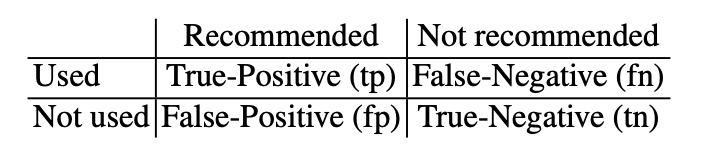

#### True positive (Recommended and Used)

In [ ]:
{'Place': 'China Doll Restaurant',
  'Catgory': "['Asian Restaurant', 'Chinese Restaurant']",
  'Distance(In km)': 2.791367229541537,
  'Similarity': 1.0000000000000002}

#### False positive (Recommended but not used)
In the offline case we are forced to assume that unused items would have not used even if they had been recommended, this assumption may be false because the user might not be aware of these places and about its existance. But after the recommendation system exposed the places the user can decide to select it. Therefore in this case the number of False positives is over estimated

In [ ]:
 {'Place': 'Golden China Buffet',
  'Catgory': "['Chinese Restaurant', 'Asian Restaurant']",
  'Distance(In km)': 1.3429198553986461,
  'Similarity': 1.0000000000000002}
 {'Place': 'Colby Teriyaki & Wok',
  'Catgory': "['Asian Restaurant', 'Chinese Restaurant']",
  'Distance(In km)': 2.1942138662869652,
  'Similarity': 1.0000000000000002},
 {'Place': 'Beijing Garden Chinese',
  'Catgory': "['Asian Restaurant', 'Chinese Restaurant']",
  'Distance(In km)': 2.043718445403108,
  'Similarity': 1.0000000000000002},
 {'Place': 'Goodworld Chinese Restaurant',
  'Catgory': "['Chinese Restaurant', 'Asian Restaurant']",
  'Distance(In km)': 2.34663297016549,
  'Similarity': 1.0000000000000002},
 {'Place': 'Hunan Wok',
  'Catgory': "['Chinese Restaurant', 'Asian Restaurant']",
  'Distance(In km)': 4.386800995237523,
  'Similarity': 1.0000000000000002},
 {'Place': 'Beijing Garden Chinese',
  'Catgory': "['Asian Restaurant', 'Chinese Restaurant']",
  'Distance(In km)': 2.043718445403108,
  'Similarity': 1.0000000000000002},
 {'Place': 'Fortune Inn',
  'Catgory': "['Asian Restaurant', 'Chinese Restaurant']",
  'Distance(In km)': 1.1433965039594702,
  'Similarity': 1.0000000000000002},
 {'Place': 'Happy Lake 1 Teriyaki Wok',
  'Catgory': "['Asian Restaurant', 'Chinese Restaurant']",
  'Distance(In km)': 2.3830457012800306,
  'Similarity': 1.0000000000000002},
 {'Place': 'Tasters Wok',
  'Catgory': "['Chinese Restaurant', 'Asian Restaurant']",
  'Distance(In km)': 4.199171869557294,
  'Similarity': 1.0000000000000002}]

We can count the number of examples that fall into each cell and compute the following:
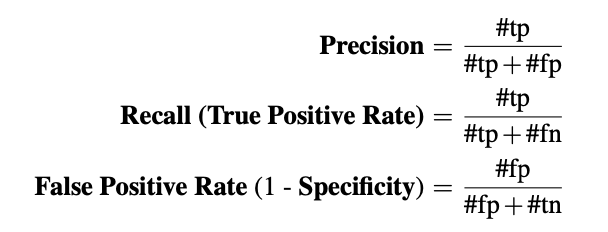

#### Precision = 1/(1+9) = 0.1

#### Recall = 1/(1+0) = 1

#### False Positive Rate = 9/(9+0) = 1

In [367]:
places_rec = recommendations_content_distance(df_cont_based, 
                                              gPlusPlaceId=109982268364798196525, 
                                              distance_limit=3,
                                              desired_similarity=0.9)

10


In [368]:
places_rec

[{'Place': 'The Mt. Washington Tavern',
  'Place_location': "['5700 Newbury St', 'Baltimore, MD 21209']",
  'lat': 39.367459999999994,
  'lon': -76.652237,
  'Catgory': "['American Restaurant']",
  'Distance(In km)': 2.4016320611051243,
  'Similarity': 0.9999999999999998},
 {'Place': 'The Dogwood Restaurant',
  'Place_location': "['911 W 36th St', 'Baltimore, MD 21211']",
  'lat': 39.331027,
  'lon': -76.631764,
  'Catgory': "['American Restaurant']",
  'Distance(In km)': 0.35750776173348636,
  'Similarity': 0.9999999999999998},
 {'Place': 'Woodberry Kitchen',
  'Place_location': "['2010 Clipper Park Rd #126', 'Baltimore, Maryland 21211']",
  'lat': 39.331771999999994,
  'lon': -76.64553599999999,
  'Catgory': "['American Restaurant']",
  'Distance(In km)': 0.5538839025501311,
  'Similarity': 0.9999999999999998},
 {'Place': 'Meet 27',
  'Place_location': "['127 W 27th St', 'Baltimore, MD 21218']",
  'lat': 39.320431,
  'lon': -76.61977900000001,
  'Catgory': "['American Restaurant']",


In [246]:
df_cont_based[80:90]

,rating,reviewerName,categories,gPlusPlaceId,gPlusUserId,user_lat,user_long,placeName,price,address,place_lat,place_long,bag_of_words
80,4.0,Jason W. Crews,['Mexican Restaurant'],113218558857589073452,100000858766569139184,32.745964,-96.997785,Don Juans,$$,['United States'],32.745398,-97.000192,mexican restaurant
81,2.0,Seobin Moon,"['Pizza Delivery', 'Takeout Restaurant']",104918922285438827538,100000890719524385306,NaN,NaN,Super Mario‎'s Pizza,$$,"['736 N Broadway St', 'Knoxville, TN 37917']",35.977419,-83.923357,pizza delivery takeout restaurant
82,5.0,Debbie Davis,"['American Restaurant', 'Fast Food Restaurant'...",102150056919327230217,100000937732473507208,NaN,NaN,Camp Washington Chilli,$$$,"['3005 Colerain Ave', 'Cincinnati, OH 45225']",39.137417,-84.537706,american restaurant fast food beverages
83,5.0,Steve LeFebvre,"['Romanian Restaurant', 'Eastern European Rest...",118279746793420842563,100000987095724371823,NaN,NaN,Bucharest Grill,$$$,"['2040 Park Ave', 'Detroit, MI 48226']",42.336915,-83.052803,romanian restaurant eastern european
84,1.0,Doug Garner,"['Steak House', 'American Restaurant', 'Barbec...",101710674346382004551,100000991955816817604,NaN,NaN,Big Daddy's Roadhouse Grill,$$,"['1610 S Kings Hwy', 'Myrtle Beach, SC 29577']",33.675222,-78.904867,steak house american restaurant barbecue
85,2.0,william holcomb,"['Hamburger Restaurant', 'Fast Food Restaurant']",117375003782548234778,100000996709496791884,NaN,NaN,Burger King,$$$,"['851 2nd Ave', 'Troy, NY 12182']",42.785125,-73.672513,hamburger restaurant fast food
86,2.0,Chad F,['American Restaurant'],115202146646029843326,100001021216880547990,NaN,NaN,Shakers American Cafe,$$$,"['1308 Edgewater Dr', 'Orlando, FL 32804']",28.563442,-81.389466,american restaurant
87,5.0,Tyler Houghton,"['Fast Food Restaurant', 'Sandwich Shop']",103714580490074430382,100001045668680522107,NaN,NaN,Sub Depot,NaN,"['6100 Fair Oaks Blvd', 'Carmichael, CA 95608']",38.611578,-121.328421,fast food restaurant sandwich shop
88,2.0,Bryan Howell,"['Department Store', 'Bakery', 'Electronics St...",103466659749209370990,100001068386913453767,NaN,NaN,Walmart Supercenter,$$$,"['7455 W Colfax Ave', 'Lakewood, CO 80214']",39.740600,-105.080900,department store bakery electronics
89,5.0,Glenn Thompson,"['Asian Restaurant', 'Mediterranean Restaurant...",113281450951970371386,100001087092021025350,NaN,NaN,Shawarma Palace,NaN,"['464 Rideau St', 'Ottawa, ON K1N 5Z3', 'Canada']",45.431064,-75.680006,asian restaurant mediterranean middle eastern


In [247]:
df_cont_based[(df_cont_based.bag_of_words=='american restaurant')]

,rating,reviewerName,categories,gPlusPlaceId,gPlusUserId,user_lat,user_long,placeName,price,address,place_lat,place_long,bag_of_words
10,2.0,Richard Yocom,['American Restaurant'],107667540471917464953,100000053212755369563,NaN,NaN,Waffle House,$$$,"['507 Bonita Rd', 'Lauderdale, MS 39301']",32.367399,-88.675488,american restaurant
11,3.0,Jackie Harvilla,['American Restaurant'],117682556988480065346,100000059843227870895,NaN,NaN,Bob Evans Restaurant,$$$,"['1400 Harrisburg Pike', 'Carlisle, PA 17015']",40.233500,-77.125550,american restaurant
52,5.0,Jason Brashear,['American Restaurant'],102193877048376077809,100000525921518075734,NaN,NaN,Christine's,NaN,"['209 N 2nd St', 'Rocky Ford, CO 81067']",38.056642,-103.727731,american restaurant
86,2.0,Chad F,['American Restaurant'],115202146646029843326,100001021216880547990,NaN,NaN,Shakers American Cafe,$$$,"['1308 Edgewater Dr', 'Orlando, FL 32804']",28.563442,-81.389466,american restaurant
92,3.0,Brian “geeknik” Carpenter,['American Restaurant'],106626489051838914024,100001092933694400300,NaN,NaN,The Delta Cafe,NaN,"['3301 S Blvd', 'Edmond, OK 73013']",35.623030,-97.480284,american restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2285563,5.0,Christopher Gross,['American Restaurant'],104048326195469426405,118445922721592942009,NaN,NaN,Woodberry Kitchen,$,"['2010 Clipper Park Rd #126', 'Baltimore, Mary...",39.331772,-76.645536,american restaurant
2285572,4.0,Christopher Gross,['American Restaurant'],107754920295795151090,118445922721592942009,NaN,NaN,Cashion's Eat Place,$,"['1819 Columbia Rd NW', 'Washington, DC 20009']",38.921855,-77.043513,american restaurant
2285575,4.0,Christopher Gross,['American Restaurant'],108589265675227232372,118445922721592942009,NaN,NaN,Fuddruckers,$$,"['1700 Reisterstown Rd', 'Pikesville, MD 21208']",39.380245,-76.731107,american restaurant
2285577,4.0,Christopher Gross,['American Restaurant'],109982268364798196525,118445922721592942009,NaN,NaN,McCabe's,$$,"['3845 Falls Rd', 'Baltimore, MD 21211']",39.334990,-76.636064,american restaurant


In [252]:
df_cont_based[(df_cont_based.gPlusUserId=='118445922721592942009')&(df_cont_based.bag_of_words=='american restaurant')]

,rating,reviewerName,categories,gPlusPlaceId,gPlusUserId,user_lat,user_long,placeName,price,address,place_lat,place_long,bag_of_words
2285563,5.0,Christopher Gross,['American Restaurant'],104048326195469426405,118445922721592942009,NaN,NaN,Woodberry Kitchen,$,"['2010 Clipper Park Rd #126', 'Baltimore, Mary...",39.331772,-76.645536,american restaurant
2285572,4.0,Christopher Gross,['American Restaurant'],107754920295795151090,118445922721592942009,NaN,NaN,Cashion's Eat Place,$,"['1819 Columbia Rd NW', 'Washington, DC 20009']",38.921855,-77.043513,american restaurant
2285575,4.0,Christopher Gross,['American Restaurant'],108589265675227232372,118445922721592942009,NaN,NaN,Fuddruckers,$$,"['1700 Reisterstown Rd', 'Pikesville, MD 21208']",39.380245,-76.731107,american restaurant
2285577,4.0,Christopher Gross,['American Restaurant'],109982268364798196525,118445922721592942009,NaN,NaN,McCabe's,$$,"['3845 Falls Rd', 'Baltimore, MD 21211']",39.334990,-76.636064,american restaurant
